# Qubit Mapping


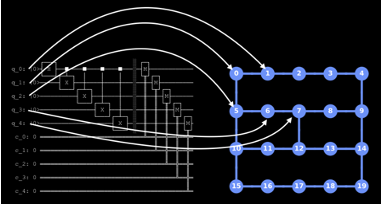

Mapping is the process of taking qubits from an algorithmic "abstract" framework to the physical ones existing on an actual quantum backend. There are two considerations when mapping a quantum circuit to a backend: the fact that most physical backends have limited qubit connectivity and the quality of the physical qubits.

Therefore we separate qubit mapping into **two** distinct processes, which also reflects that they are solved by two separate classical algorithms:
- **Routing**: Finding the least number of `SWAP` gates needed to route quantum information given limited connectivity
- **Layout**: Finding the best qubits (given some metric or cost function) that respects the topology given by the Routing pass

Note that both of these problems are NP-hard, and hence we use stochastic algorithms SABRE and VF2, respectively. For better performance especially on larger number of qubits, consider running each several times, using the metrics
- `qc_l.count_ops()['swap']` for SABRE routing
- `scored_layouts[0][1]` for mapomatic / VF2 layout
where, like golf, lower is better.

## Start
We'll test this out on a non-trival example of 5-qubit GHZ state 
$$
|\psi_{\rm GHZ}\rangle = \frac{1}{\sqrt{2^5}} \left( |00000\rangle + |11111\rangle \right)
$$
on the 27-qubit `ibm_kolkata`, (but feel free to try out other numbers of qubits yourself!).

## Build

In [ ]:
# ideal circuit in a 1D chain, different graphs
# transpiler starts with a graph, but for GHZ, they are smarter graph

In [ ]:
# https://qiskit.org/documentation/stubs/qiskit.algorithms.state_fidelities.ComputeUncompute.html#qiskit.algorithms.state_fidelities.ComputeUncompute.run

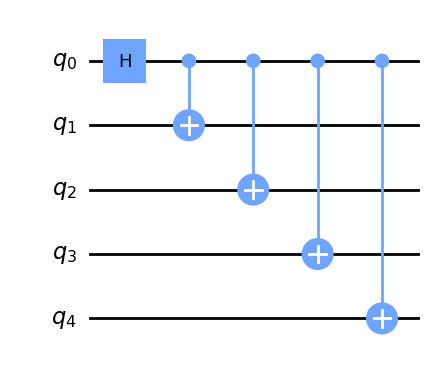

In [29]:
from qiskit.circuit import QuantumCircuit

num_qubits = 5
qc = QuantumCircuit(num_qubits)
qc.h(0)
[qc.cx(0, idx) for idx in range(1, num_qubits)]
qc.draw('mpl')

## Transpile

### Routing

Given the limited topology of current backends (a qubit in a heavy-hex device has at most 3 connected qubits), this circuit guarantees at least one `SWAP` gate is needed. Make note that there are more efficient ways to generate a 5-qubit GHZ state, but this all-to-one connectivity will test the algorithm behind Routing.

We start by initializing a temporary preset pass manager at `optimization_level=1` (all optimization levels greater than zero user the SABRE algorithm in recent versions of Qiskit) for the backend `FakeKolkata` (because I am writing this on a plane).

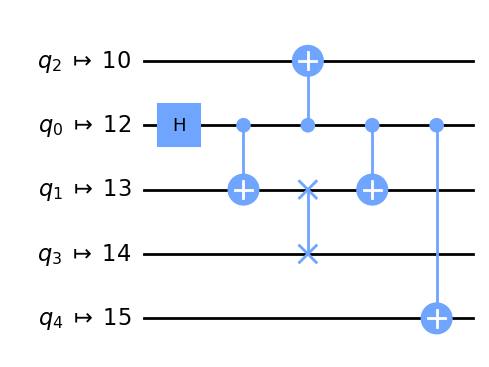

In [2]:
from qiskit.providers.fake_provider import FakeKolkata
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeKolkata()
temp_pm = generate_preset_pass_manager(1, backend)
qc_l = temp_pm.layout.run(qc)
qc_l.draw('mpl', idle_wires=False)



We see the circuit now has a `SWAP` inserted that reflects that one of the qubits is not connected to the center one. However, it also has assigned physical qubits to the circuit as well, meaning the pass manager stage also performed *layout*. In the next stage we will remove the qubit assignments and perform Layout with a different algorithm.

### Layout

Now we use a tool called `mapomatic`, a wrapper for the VF2 algorithm, to find the least error-prone qubits for the given topology found in the routing stage. The error is specified by a default `cost_func` that multiplies the fidelities of all the gate operations together and inverts it for a type of "infidelity score" (again, the lower the better). This proceeds in four steps.

- **Step 1:** Translate the circuit into the basis gates for scoring. Since only the native basis gates are calibrated and characterized, we must *translate* gates that are non-native, here the Hadamard and `SWAP` will be translated.

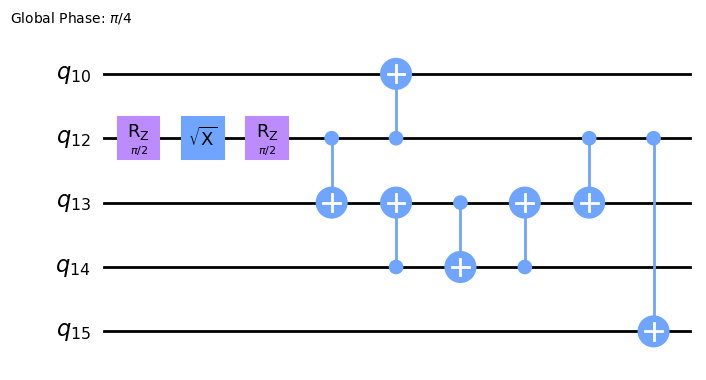

In [7]:
qc_tr = temp_pm.translation.run(qc_l)
qc_tr.draw('mpl', idle_wires=False)

Now that we only have basis gates remaining (`rz`, `sx`, and `cx`), it is time for

- **Step 2**: forget the qubit assignments (we are showing just 5 qubits above, but the other 22 "idle" qubits have been assigned as well). We use the `deflate_circuit` from `mapomatic` for this.

   - Step 2a: Install `mapomatic` if you have not already.

In [8]:
# !pip install mapomatic

- 
   - Step 2b: Deflate the circuit.

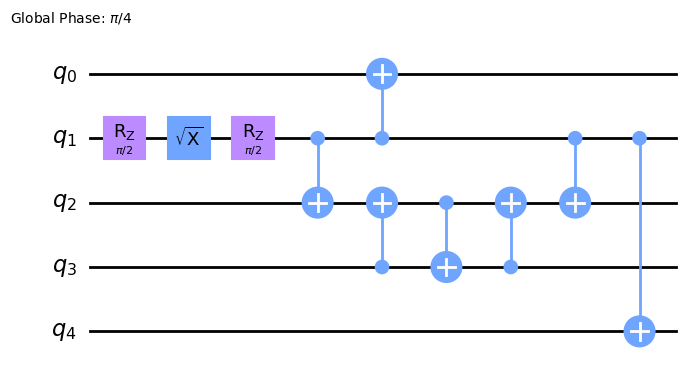

In [9]:
from mapomatic import deflate_circuit

qc_d = deflate_circuit(qc_tr)
qc_d.draw('mpl')

Note that the `idle_wires` flag was not necessary because we have returned to our original "abstract" circuit qubit numbering `q0`-`q4`.

- **Step 2**: Find all possible layouts and score them, ordered in increasing infidelity score. Each element of the list is a pair of the layout and its score.

In [58]:
from mapomatic import evaluate_layouts, matching_layouts

layouts = matching_layouts(qc_d, backend.configuration().coupling_map)

# add description about cost function
scored_layouts = evaluate_layouts(qc_d, layouts, backend)
scored_layouts

[([22, 25, 24, 23, 26], 0.04264756934881142),
 ([26, 25, 24, 23, 22], 0.04264756934881153),
 ([10, 7, 4, 1, 6], 0.04514199511205086),
 ([6, 7, 4, 1, 10], 0.04514199511205086),
 ([15, 12, 13, 14, 10], 0.046742145481986186),
 ([10, 12, 13, 14, 15], 0.04674214548198641),
 ([4, 1, 2, 3, 0], 0.051551809758244915),
 ([0, 1, 2, 3, 4], 0.051551809758245026),
 ([26, 25, 22, 19, 24], 0.05160300111190219),
 ([24, 25, 22, 19, 26], 0.0516030011119023),
 ([0, 1, 4, 7, 2], 0.0522569000089087),
 ([2, 1, 4, 7, 0], 0.052256900008908924),
 ([22, 19, 16, 14, 20], 0.05548347725405545),
 ([20, 19, 16, 14, 22], 0.05548347725405556),
 ([13, 12, 10, 7, 15], 0.05869563584275528),
 ([15, 12, 10, 7, 13], 0.05869563584275528),
 ([15, 18, 21, 23, 17], 0.06172572084892691),
 ([17, 18, 21, 23, 15], 0.061725720848927024),
 ([20, 19, 22, 25, 16], 0.06233942975634921),
 ([16, 19, 22, 25, 20], 0.06233942975634932),
 ([4, 7, 10, 12, 6], 0.06333491008397696),
 ([6, 7, 10, 12, 4], 0.06333491008397707),
 ([17, 18, 15, 12, 21

Note there's $\sim 5\times$ range over these layouts. We wish to pick the best one, which leads us to

- **Step 4:** Pick the best layout and construct a new pass manager from it, which requires an awkward method of the `Layout` class. Then use that to run the layout stage at the desired optimization level (we use 2 in this case) on the deflated circuit (the "abstract" routed circuit).

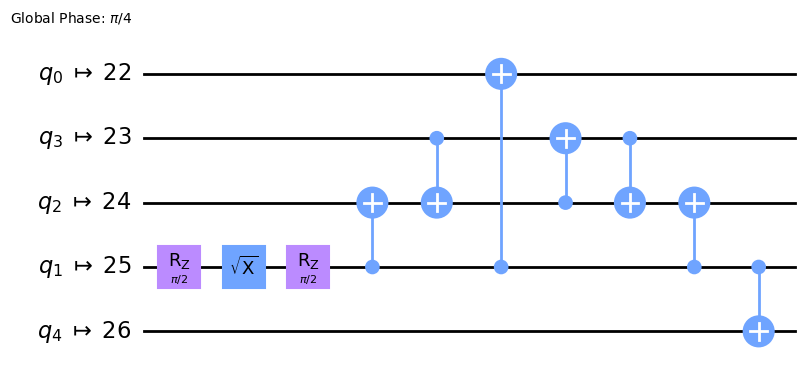

In [59]:
from qiskit.transpiler import Layout

init_layout = scored_layouts[0][0]
layout = Layout().from_intlist(init_layout, *qc_d.qregs)
pm = generate_preset_pass_manager(2, backend, initial_layout=layout)
qc_l = pm.layout.run(qc_d)
qc_l.draw('mpl', idle_wires=False)

As an exercise, let's confirm `q23`-`q24` has the lowest `cx` error (after all, there are 4 `cx`'s present)

In [ ]:
props = backend.properties()
conf = backend.configuration()

print(f' Busy qubit error is {props.gate_error("cx", qubits=[23, 24])} while \
      unoptimized qubit error is {props.gate_error("cx", qubits=[13, 14])} and \
      minimum error is {min([props.gate_error("cx", qubits=pair) for pair in conf.coupling_map])}')

 Busy qubit error is 0.005343381278673259 while       minimum error is 0.005007809095699811


## Verify

Before running on the hardware, let's debug/test our circuits by running it on the simulator. 



In [46]:
from qiskit_ibm_runtime import Sampler

sampler = Sampler(backend='ibmq_qasm_simulator')

qc_l.measure_active()

sim_job = sampler.run(qc_l, shots=10000)
# state vector 
sim_result = sim_job.result()

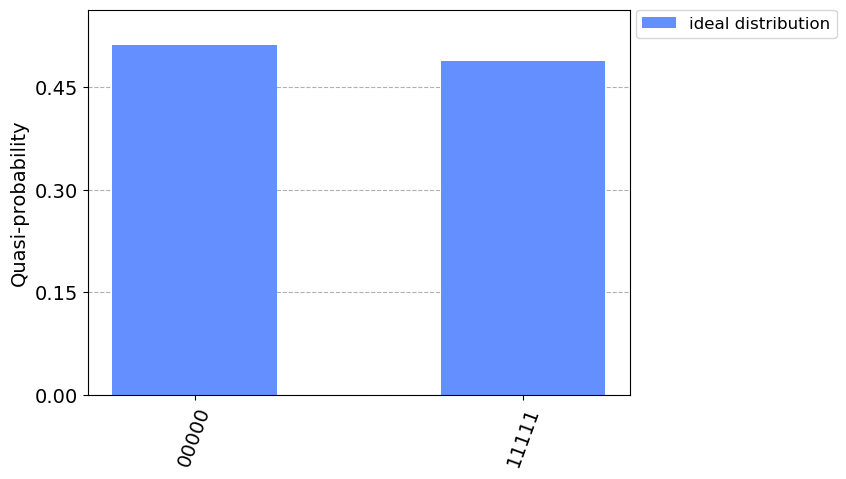

In [53]:
from qiskit.visualization import plot_histogram

# binary_prob = [quasi_dist.binary_probabilities() for res in [result, sim_result] for quasi_dist in res.quasi_dists]
plot_histogram(
    sim_result.quasi_dists[0].binary_probabilities(),
    bar_labels=False,
    legend=[
        "ideal distribution",
    ],
)

## Run

Finally, we run the transpiled circuit on the hardware using the Runtime. To compare, we also run the transpiled circuit without picking the best qubits to use. Termed as "unoptimized". Do `skip_transpilation = True` 

In [48]:
from qiskit_ibm_runtime import Options

options = Options()

options.transpilation.skip_transpilation = True

options.resilience_level = 1

sampler = Sampler(backend = 'ibmq_kolkata', options=options)

optimized_job = sampler.run(qc_l, shots=10000)

# comparison
qc_tr.measure_active()
unoptimized_job = sampler.run(qc_tr, shots=10000)


In [67]:
# get result
unoptimized_result = unoptimized_job.result()
optimized_result = optimized_job.result()

# add a paragraph analyze the result

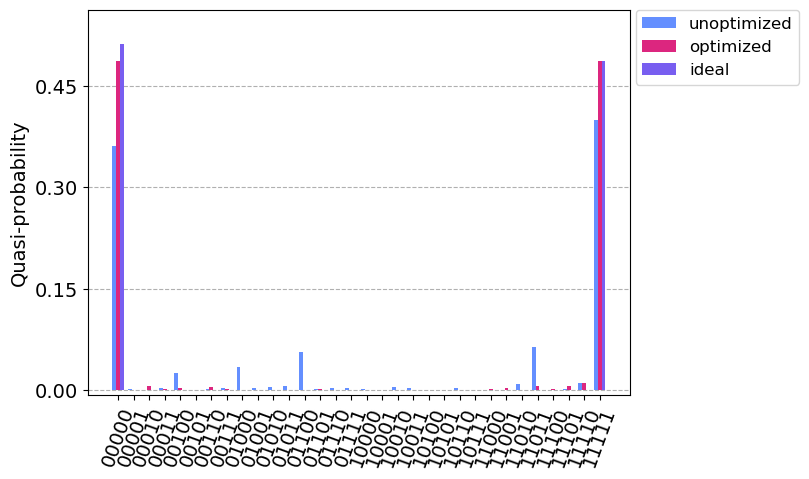

In [72]:
plot_histogram(
    [result.quasi_dists[0].binary_probabilities() for result in [unoptimized_result, optimized_result, sim_result]],
    bar_labels=False,
    legend=[
        "unoptimized",
        "optimized",
        "ideal"
    ],
)

In [ ]:
# print Hellinger fideltiy between bitstrings